# Data Loading

In [ ]:
pip install kaggle

In [1]:
!pip install -q kaggle
from google.colab import userdata
import json
import os

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

kaggle_creds = {
    "username": userdata.get('KAGGLE_USERNAME'),
    "key": userdata.get('KAGGLE_KEY')
}

# Write credentials file
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aramacus/electricity-demand-in-victoria-australia --unzip -p /content/data

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/data/complete_dataset.csv', encoding='latin1')
df

# EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert `Date` column to datetime
df['Date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by='Date')

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot Demand over time
sns.lineplot(data=df, x='Date', y='demand', ax=axes[0])
axes[0].set_title('Electricity Demand Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Demand')

# Plot RRP over time
sns.lineplot(data=df, x='Date', y='RRP', ax=axes[1])
axes[1].set_title('Regional Reference Price (RRP) Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('RRP')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
# Filter the dataframe to only include rows where RRP is less than or equal to 200
df = df[df['RRP'] <= 200].copy()

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot Demand over time
sns.lineplot(data=df, x='Date', y='demand', ax=axes[0])
axes[0].set_title('Electricity Demand Over Time (RRP <= 200)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Demand')

# Plot RRP over time
sns.lineplot(data=df, x='Date', y='RRP', ax=axes[1])
axes[1].set_title('Regional Reference Price (RRP) Over Time (RRP <= 200)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('RRP')

plt.tight_layout()
plt.show()

# LSTM

In [ ]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day


In [ ]:
import numpy as np

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['year_norm'] = (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min())

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


class DemandDataset(Dataset):
    def __init__(self, df, seq_length=90):
        self.seq_length = seq_length

        self.scaler_price = MinMaxScaler()
        self.scaler_demand = MinMaxScaler()

        # Fit scalers on log-transformed data
        price = df[['RRP']].values.astype(np.float32)
        sales = df[['demand']].values.astype(np.float32)

        self.scaler_price.fit(price)
        self.scaler_demand.fit(sales)

        price_scaled = self.scaler_price.transform(price)
        demand_scaled = self.scaler_demand.transform(sales)

        # Other features
        month_sin = df['month_sin'].values.reshape(-1, 1).astype(np.float32)
        month_cos = df['month_cos'].values.reshape(-1, 1).astype(np.float32)
        year_norm = df['year_norm'].values.reshape(-1, 1).astype(np.float32)

        # Combine features: price_scaled, sales_scaled, year_norm, month_sin, month_cos
        self.features = np.hstack([demand_scaled, year_norm, month_sin, month_cos])

    def __len__(self):
        return len(self.features) - self.seq_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.features[idx + self.seq_length, 0]  # sales (scaled)
        return torch.FloatTensor(x), torch.FloatTensor([y])


class DemandPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=64, num_layers=2,
                            batch_first=True, dropout=0.3)
        self.layer_norm = nn.LayerNorm(64)
        self.attention = nn.Sequential(
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.layer_norm(lstm_out)
        attn_weights = self.attention(lstm_out)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        return self.fc(context)


In [ ]:
def train_model():
    seq_length = 90
    dataset = DemandDataset(df, seq_length)

    train_size = int(0.8 * len(dataset))
    indices = list(range(len(dataset)))

    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    from torch.utils.data import Subset

    train_data = Subset(dataset, train_indices)
    test_data = Subset(dataset, test_indices)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DemandPredictor().to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
    criterion = nn.MSELoss()

    for epoch in range(30):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                val_loss += criterion(outputs, y).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(test_loader)
        print(f'Epoch {epoch+1}: Train Loss {avg_train:.6f}, Val Loss {avg_val:.6f}')
        scheduler.step(val_loss)

    return model, test_loader, device

def plot_results(model, test_loader, device):
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            pred = model(x)
            preds.extend(pred.cpu().numpy())
            truths.extend(y.numpy())

    plt.figure(figsize=(12, 6))
    plt.plot(truths, label='True Demand')
    plt.plot(preds, label='Predicted Demand', alpha=0.7)
    plt.legend()
    plt.show()

In [ ]:
model, test_loader, device = train_model()
plot_results(model, test_loader, device)

# Elasticity

In [ ]:
import statsmodels.api as sm
import numpy as np
import statsmodels.api as sm

df = df[(df['demand'] > 0) & (df['RRP'] > 0)].copy()
df['log_demand'] = np.log(df['demand'])
df['log_price'] = np.log(df['RRP'])

elasticity_map = {}
intercept_map = {}
average_price_map = {}

for month, group in df.groupby('month'):
    if len(group) > 5:
        X = sm.add_constant(group['log_price'])
        y = group['log_demand']
        ols = sm.OLS(y, X).fit()
        elasticity = ols.params['log_price']
        intercept = ols.params['const']  # This is the intercept
        elasticity_map[month] = float(elasticity)
        intercept_map[month] = float(intercept)
        average_price_map[month] = float(np.exp(group['log_price'].mean()))

elasticity_map

In [ ]:
average_price_map

# RL

In [ ]:
pip install stable-baselines3[extra]

RL environment creation

In [ ]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

class RetailPricingEnv(gym.Env):
    def __init__(
        self,
        lstm_model,
        scaler_price,
        scaler_demand,
        elasticity_map,
        average_price_map,
        price_thresholds,
        start_year=2015,
        start_month=1,
        start_day=1,
        seq_length=90,
        max_steps=730
    ):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Functions
        self.lstm_model = lstm_model.to(self.device)
        self.scaler_price = scaler_price
        self.scaler_demand = scaler_demand
        self.elasticity_map = elasticity_map
        self.q1, self.q2, self.q3 = price_thresholds
        self.average_price_map = average_price_map

        # Time tracking
        self.seq_length = seq_length
        self.year_min = 2015
        self.year_max = 2022
        self.max_steps = max_steps
        self.step_count = 0

        # Time features
        self.feature_dim = 4

        # Observation space
        history_low = np.array([0, 0, -1, -1] * seq_length)
        history_high = np.array([2, 1, 1, 1] * seq_length)
        price_history_low = np.array([0] * seq_length)
        price_history_high = np.array([1] * seq_length)
        extra_low = np.array([0, -1, -1, 0])
        extra_high = np.array([1, 1, 1, 1])

        low = np.concatenate([history_low, price_history_low, extra_low])
        high = np.concatenate([history_high, price_history_high, extra_high])

        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Internal state
        self.history = None
        self.price_history = None
        self.prev_price_scaled = None
        self.logged_data = {}
        self.training = True

        # Current time
        self.day = start_day
        self.month = start_month
        self.year = start_year

    def set_training(self, mode=True):
        self.training = mode

    def _time_features(self):
        year_norm = (self.year - self.year_min) / (self.year_max - self.year_min)
        month_sin = np.sin(2 * np.pi * self.month / 12)
        month_cos = np.cos(2 * np.pi * self.month / 12)
        return year_norm, month_sin, month_cos

    def _build_obs(self, price_scaled):
        year_norm, month_sin, month_cos = self._time_features()
        return np.concatenate([
            self.history.flatten(),
            self.price_history.flatten(),
            [price_scaled, month_sin, month_cos, year_norm]
        ]).astype(np.float32)

    def price_level(self, price_real):
        if price_real <= self.q1:
            return "low"
        elif price_real <= self.q2:
            return "medium"
        elif price_real <= self.q3:
            return "high"
        else:
            return "very_high"

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        price_scaled = 0.3
        demand_scaled = 0.3
        self.step_count = 0
        self.prev_price_scaled = price_scaled

        if self.training:
            # Random month during training
            self.year = np.random.randint(self.year_min, 2019)
            self.month = np.random.randint(1, 13)
            self.day = 1
        else:
            # Fixed eval start date
            self.year = 2019
            self.month = 1
            self.day = 1

        year_norm, month_sin, month_cos = self._time_features()
        row = np.array([demand_scaled, year_norm, month_sin, month_cos], dtype=np.float32)

        self.history = np.tile(row, (self.seq_length, 1))
        self.price_history = np.full((self.seq_length, 1), price_scaled, dtype=np.float32)

        self.logged_data = {
            "price": [], "demand": [], "reward": [],
            "year": [], "month": [], "elasticity": []
        }

        return self._build_obs(price_scaled), {}

    def step(self, action):
        self.step_count += 1

        price_scaled = np.clip((action[0] + 1) / 2, 0.05, 1)
        price_real = float(self.scaler_price.inverse_transform([[price_scaled]])[0][0])
        prev_price_real = float(self.scaler_price.inverse_transform([[self.prev_price_scaled]])[0][0])
        price_real = max(price_real, 0.01)
        prev_price_real = max(prev_price_real, 0.01)
        price_pct_change = (price_real - prev_price_real) / prev_price_real

        # Predict baseline demand
        input_seq = torch.FloatTensor(self.history).unsqueeze(0).to(self.device)
        self.lstm_model.eval()
        with torch.no_grad():
            pred_demand_scaled = self.lstm_model(input_seq)[0, 0].item()
        demand_baseline_real = float(self.scaler_demand.inverse_transform([[pred_demand_scaled]])[0][0])

        # Elasticity adjustment
        price_level = self.price_level(price_real)
        elasticity = self.elasticity_map.get((self.month)) * -1

        price_ref = self.average_price_map.get((self.month))
        price_ratio = max(price_real / price_ref, 1e-6)
        demand_adjusted_real = demand_baseline_real * (price_ratio ** elasticity)
        demand_adjusted_real = np.clip(demand_adjusted_real, 0, 2 * demand_baseline_real)

        if self.training:
            noise_std = 0.08 * demand_adjusted_real
            demand_adjusted_real = max(demand_adjusted_real + np.random.normal(0, noise_std), 0)

        reward = price_real * demand_adjusted_real / 10000000

        # Update histories
        demand_adjusted_scaled = max(self.scaler_demand.transform([[demand_adjusted_real]])[0][0], 0)
        year_norm, month_sin, month_cos = self._time_features()

        new_row = np.array([demand_adjusted_scaled, year_norm, month_sin, month_cos], dtype=np.float32)
        self.history = np.vstack([self.history[1:], new_row])
        self.price_history = np.vstack([self.price_history[1:], [price_scaled]])
        self.prev_price_scaled = price_scaled

        # Logging
        self.logged_data["price"].append(price_real)
        self.logged_data["demand"].append(demand_adjusted_real)
        self.logged_data["reward"].append(reward)
        self.logged_data["year"].append(self.year)
        self.logged_data["month"].append(self.month)
        self.logged_data["elasticity"].append(elasticity)

        # Advance time
        self.day += 1
        if self.day > 30:
            self.day = 1
            self.month += 1
            if self.month > 12:
                self.month = 1
                self.year += 1
                if self.year > self.year_max:
                    self.year = self.year_min

        # Done
        terminated = self.step_count >= self.max_steps
        truncated = False

        obs = self._build_obs(price_scaled)
        info = {
            "predicted_demand_scaled": pred_demand_scaled,
            "demand_adjusted_real": demand_adjusted_real,
            "price_real": price_real,
            "reward": reward,
            "elasticity": elasticity,
            "price_pct_change": price_pct_change,
            "step": self.step_count,
            "year": self.year,
            "month": self.month
        }

        return obs, reward, terminated, truncated, info


Scaler set

In [ ]:
from sklearn.preprocessing import MinMaxScaler

price =(df[['RRP']].values.astype(np.float32))
demand = (df[['demand']].values.astype(np.float32))

scaler_price = MinMaxScaler()
scaler_demand = MinMaxScaler()

scaler_price.fit(price)
scaler_demand.fit(demand)

Environment wrapper and creation

In [ ]:
from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
q1=1
q2=2
q3=3
# Create environment instance
env = RetailPricingEnv(
    lstm_model=model,
    scaler_price=scaler_price,
    scaler_demand=scaler_demand,
    elasticity_map=elasticity_map,
    average_price_map=average_price_map,
    price_thresholds=(q1, q2, q3),
    seq_length=90
)

# Check env
check_env(env, warn=True)
env.set_training(True)
vec_env = DummyVecEnv([lambda: env])


Agent creation and training

In [ ]:
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

agent = DDPG(
    "MlpPolicy",
    env,
    learning_rate=3e-5,
    buffer_size=500_000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=(1, "step"),
    gradient_steps=1,
    #policy_delay=2,
    action_noise=action_noise,
    verbose=1
)

agent.learn(total_timesteps=4000)
agent.save("DDPG_retail_pricing")


In [ ]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeLossCallback(BaseCallback):
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self.episode_rewards = []
        self.ep_len = 0

    def _on_step(self) -> bool:
        self.ep_len += 1
        if self.locals.get("dones") is not None and np.any(self.locals["dones"]):
            if hasattr(self.model, "logger"):
                actor_loss = self.model.logger.name_to_value.get("train/actor_loss", None)
                critic_loss = self.model.logger.name_to_value.get("train/critic_loss", None)
                print(f"Episode done (len={self.ep_len}): Actor Loss={actor_loss}, Critic Loss={critic_loss}")
            self.ep_len = 0
        return True


In [ ]:
agent.learn(total_timesteps=4000, callback=EpisodeLossCallback())

## Plotting

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert logs to DataFrame
logs_df = pd.DataFrame(env.logged_data)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot Price
axes[0].plot(logs_df["price"], color='blue')
axes[0].set_ylabel("Price")
axes[0].set_title("Price over Time")

# Plot Demand
axes[1].plot(logs_df["demand"], color='green')
axes[1].set_ylabel("Demand")
axes[1].set_title("Demand over Time")

# Plot Reward
axes[2].plot(logs_df["reward"], color='orange')
axes[2].set_ylabel("Reward")
axes[2].set_title("Revenue over Time")

# Plot Elasticity
if "elasticity" in logs_df.columns:
    axes[3].plot(logs_df["elasticity"], color='red')
    axes[3].set_ylabel("Elasticity")
    axes[3].set_title("Elasticity over Time")

axes[3].set_xlabel("Step")

plt.tight_layout()
plt.show()


# MARL

In [ ]:
pip install pettingzoo

MARL environment creation

In [ ]:
from pettingzoo import ParallelEnv
from gymnasium import spaces
import numpy as np
import torch
from collections import deque

class RetailPricingParallelEnv(ParallelEnv):
    metadata = {"render_modes": ["human"], "name": "retail_pricing_v4"}

    def __init__(self, lstm_model, scaler_price, scaler_demand,
                 elasticity_map, num_agents=2, seq_length=90,
                 max_steps=730, start_year=2015, start_month=1,
                 reference_price=55.0, agent_history_length=5):

        self.lstm_model = lstm_model.eval()
        self.scaler_price = scaler_price
        self.scaler_demand = scaler_demand

        self._num_agents = num_agents
        self.seq_length = seq_length
        self.agent_history_length = agent_history_length
        self.max_steps = max_steps
        self.reference_price = reference_price

        self.agents = [f"retailer_{i}" for i in range(num_agents)]
        self.possible_agents = self.agents.copy()

        self.year = start_year
        self.month = start_month
        self.day = 1
        self.year_range = (2015, 2024)
        self.step_count = 0

        self.elasticity_map = elasticity_map
        self.price_history_len = 30

        self._setup_observation_space()

        self.action_spaces = {
            agent: spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
            for agent in self.agents
        }

        self.histories = {agent: {
            'demand': deque(maxlen=seq_length),
            'price': deque(maxlen=self.price_history_len)
        } for agent in self.agents}

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lstm_model = self.lstm_model.to(self.device)

    def _setup_observation_space(self):
        seq_len = self.agent_history_length
        history_low = np.tile([0.0, 0.0, -1.0, -1.0], self.agent_history_length)
        history_high = np.tile([1.0, 1.0, 1.0, 1.0], self.agent_history_length)

        price_low = np.zeros(self.agent_history_length)
        price_high = np.ones(self.agent_history_length)

        num_other_agents = self._num_agents - 1
        other_prices_low = np.zeros(num_other_agents * self.agent_history_length)
        other_prices_high = np.ones(num_other_agents * self.agent_history_length)


        current_low = [0.0, -1.0, -1.0, 0.0]
        current_high = [1.0, 1.0, 1.0, 1.0]

        obs_low = np.concatenate([history_low, price_low, other_prices_low, current_low])
        obs_high = np.concatenate([history_high, price_high, other_prices_high, current_high])



        self.observation_spaces = {
            agent: spaces.Box(low=obs_low.astype(np.float32), high=obs_high.astype(np.float32), dtype=np.float32)
            for agent in self.agents
        }


    def _time_features(self):
        year_norm = (self.year - self.year_range[0]) / (self.year_range[1] - self.year_range[0])
        month_angle = 2 * np.pi * self.month / 12
        return year_norm, np.sin(month_angle), np.cos(month_angle)

    def reset(self, seed=None, options=None):
        self.step_count = 0
        self.day = 1
        self.month = 1
        self.year = 2015

        year_norm, month_sin, month_cos = self._time_features()
        init_demand = 0.3
        init_price = 0.3

        for agent in self.agents:
            self.histories[agent]['demand'] = deque(
                [[init_demand, year_norm, month_sin, month_cos]] * self.seq_length,
                maxlen=self.seq_length
            )
            self.histories[agent]['price'] = deque(
                [float(init_price)] * self.price_history_len,
                maxlen=self.price_history_len
            )

        return self._get_observations(), {}

    def _get_observations(self):
        observations = {}
        agent_history_length = self.agent_history_length
        num_agents = self._num_agents

        year_norm, month_sin, month_cos = self._time_features()
        self.year_norm = year_norm
        self.month_sin = month_sin
        self.month_cos = month_cos

        for agent in self.agents:
            idx = self.agents.index(agent)

            # own demand history
            demand_history = np.array(self.histories[agent]['demand'], dtype=np.float32)[-agent_history_length:]

            # own price history
            price_history = np.array(self.histories[agent]['price'], dtype=np.float32)[-agent_history_length:]

            # opponents price histories
            other_prices_histories = np.concatenate([
                np.array(self.histories[self.agents[j]]['price'], dtype=np.float32)[-agent_history_length:]
                for j in range(num_agents) if j != idx
            ])

            # current features: own last price + time features (4,)
            current_features = np.array([
                price_history[-1] if len(price_history) > 0 else 0.0,
                month_sin,
                month_cos,
                year_norm,
            ], dtype=np.float32)

            observations[agent] = np.concatenate([
                demand_history.flatten(),
                price_history,
                other_prices_histories,
                current_features
            ]).astype(np.float32)

        return observations





    def step(self, actions):
        self.step_count += 1

        prices_scaled, prices_real, market_shares, avg_price = self._calculate_market_shares(actions)
        demands_scaled, demands_real, total_demand_real = self._calculate_demands(market_shares, avg_price)

        revenues = {
            agent: prices_real[agent] * demands_real[agent] / 1e7
            for agent in self.agents
        }

        rewards = {}
        for agent in self.agents:
            other_agents = [a for a in self.agents if a != agent]
            if len(other_agents) > 0:
                mean_other_revenue = np.mean([revenues[a] for a in other_agents])
            else:
                mean_other_revenue = 0.0
            rewards[agent] = revenues[agent]- mean_other_revenue * 0.70

        self._update_histories(prices_scaled, demands_scaled)

        observations = self._get_observations()
        terminations = {agent: self.step_count >= self.max_steps for agent in self.agents}
        truncations = {agent: False for agent in self.agents}
        infos = self._collect_step_info(prices_real, demands_real, market_shares, avg_price, total_demand_real)

        self._advance_time()
       # print(f"Step: {self.step_count}, Year: {self.year}, Month: {self.month}, Day: {self.day}")
        return observations, rewards, terminations, truncations, infos

    def _collect_step_info(self, prices_real, demands_real, market_shares, avg_price, total_demand_real):
        date_str = f"{self.year:04d}-{self.month:02d}-{self.day:02d}"

        infos = {}
        for agent in self.agents:
            infos[agent] = {
                "date": date_str,
                "price": prices_real[agent],
                "demand": demands_real[agent],
                "market_share": market_shares[agent],
                "avg_price": avg_price,
                "total_demand": total_demand_real,
                "elasticity": self.elasticity_map.get(self.month)*-60,
            }
        return infos

    def _calculate_market_shares(self, actions):
        prices_scaled = {
            agent: float(np.clip((action[0] + 1) / 2, 0.001, 1.0))
            for agent, action in actions.items()
        }

        prices_scaled_array = np.array([[p] for p in prices_scaled.values()], dtype=np.float32)
        prices_real_array = self.scaler_price.inverse_transform(prices_scaled_array)

        prices_real = {
            agent: float(prices_real_array[i][0])
            for i, agent in enumerate(self.agents)
        }

        alpha = abs(self.elasticity_map.get(self.month)) *60

        # Avoid division by zero
        min_price = min(prices_real.values())
        prices_clipped = {
            agent: max(price, 1e-3) for agent, price in prices_real.items()
        }

        # Weight without softmax
        price_power = {
            agent: price ** -alpha
            for agent, price in prices_clipped.items()
        }
        sum_power = sum(price_power.values())

        market_shares = {
            agent: price_power[agent] / sum_power
            for agent in self.agents
        }


        avg_price = sum(market_shares[agent] * prices_real[agent] for agent in self.agents)
        return prices_scaled, prices_real, market_shares, avg_price

    def _calculate_demands(self, market_shares, avg_price):
        agent = self.agents[0]
        history_array = np.array(self.histories[agent]['demand'], dtype=np.float32)
        input_tensor = torch.FloatTensor(history_array).unsqueeze(0).to(self.device)

        with torch.no_grad():
            baseline_scaled = self.lstm_model(input_tensor)[0, 0].item()

        epsilon = self.elasticity_map.get(self.month) *-1
        adj_factor = (avg_price / self.reference_price) ** epsilon
        total_scaled_demand = max(baseline_scaled * adj_factor, 0)

        total_real_demand_array = np.array([[total_scaled_demand]], dtype=np.float32)
        total_real_demand = float(self.scaler_demand.inverse_transform(total_real_demand_array)[0][0])

        demands_scaled = {
            agent: market_shares[agent] * total_scaled_demand
            for agent in self.agents
        }
        demands_real = {
            agent: market_shares[agent] * total_real_demand
            for agent in self.agents
        }

        return demands_scaled, demands_real, total_real_demand

    def _update_histories(self, prices_scaled, demands_scaled):
        year_norm, month_sin, month_cos = self._time_features()
        for agent in self.agents:

            self.histories[agent]['demand'].append(
                [demands_scaled[agent], year_norm, month_sin, month_cos]
            )
            self.histories[agent]['price'].append(float(prices_scaled[agent]))

    def _advance_time(self):
        self.day += 1
        if self.day > 30:
            self.day = 1
            self.month += 1
            if self.month > 12:
                self.month = 1
                self.year += 1

    def _collect_step_info(self, prices_real, demands_real, market_shares, avg_price, total_demand_real):
        return {
            agent: {
                "price": prices_real[agent],
                "demand": demands_real[agent],
                "market_share": market_shares[agent],
                "avg_market_price": avg_price,
                "total_real_demand": total_demand_real,
                "year": self.year,
                "month": self.month,
                "day": self.day,
                "elasticity": self.elasticity_map.get(self.month)*-60,
                "step": self.step_count
            }
            for agent in self.agents
        }

    def render(self):
        pass

    def close(self):
        pass


    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def action_space(self, agent):
        return self.action_spaces[agent]

    def observe(self, agent):
        return self._get_observations()[agent]

MARL agent and training creation

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from collections import deque, namedtuple
import random
from pettingzoo.utils.wrappers import BaseParallelWrapper
from pettingzoo.utils.conversions import parallel_wrapper_fn

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Replay Buffer ===
Transition = namedtuple("Transition", ["obs", "act", "rew", "next_obs", "done"])

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))
        return batch

    def __len__(self):
        return len(self.buffer)

# === MLP Network ===
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_sizes=[128, 128], activation=nn.ReLU):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_sizes
        for i in range(len(dims) - 1):
            layers += [nn.Linear(dims[i], dims[i + 1]), activation()]
        layers.append(nn.Linear(dims[-1], output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# === MADDPG Agent ===
class MADDPGAgent:
    def __init__(self, agent_id, obs_dim, act_dim, num_agents, lr=1e-3):
        self.actor = MLP(obs_dim, act_dim).to(device)
        self.critic = MLP(obs_dim * num_agents + act_dim * num_agents, 1).to(device)
        self.target_actor = MLP(obs_dim, act_dim).to(device)
        self.target_critic = MLP(obs_dim * num_agents + act_dim * num_agents, 1).to(device)

        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr)

        self.agent_id = agent_id

    def select_action(self, obs, noise_scale=0.0):
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        with torch.no_grad():
            action = self.actor(obs_tensor).cpu().numpy()[0]
        if noise_scale > 0:
            action += np.random.normal(0, noise_scale, size=action.shape)
        return np.clip(action, -1, 1)

# === Soft Update ===
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

# === Train Function ===
def train_maddpg(agents, buffer, batch_size, gamma, tau):
    if len(buffer) < batch_size:
        return None  # No training yet

    batch = buffer.sample(batch_size)
    obs_batch = torch.FloatTensor(np.array(batch.obs)).to(device)
    act_batch = torch.FloatTensor(np.array(batch.act)).to(device)
    rew_batch = torch.FloatTensor(np.array(batch.rew)).to(device)
    next_obs_batch = torch.FloatTensor(np.array(batch.next_obs)).to(device)
    done_batch = torch.FloatTensor(np.array(batch.done)).to(device)

    num_agents = len(agents)
    losses = []

    for i, agent in enumerate(agents):
        # === Critic Update ===
        next_actions = [a.target_actor(next_obs_batch[:, j]) for j, a in enumerate(agents)]
        next_actions_cat = torch.cat(next_actions, dim=1)
        next_obs_cat = next_obs_batch.view(batch_size, -1)
        target_q = agent.target_critic(torch.cat([next_obs_cat, next_actions_cat], dim=1))
        target_q = rew_batch[:, i].unsqueeze(1) + gamma * target_q * (1 - done_batch[:, i].unsqueeze(1))

        curr_actions_cat = act_batch.view(batch_size, -1)
        obs_cat = obs_batch.view(batch_size, -1)
        current_q = agent.critic(torch.cat([obs_cat, curr_actions_cat], dim=1))

        critic_loss = nn.MSELoss()(current_q, target_q.detach())
        agent.critic_optimizer.zero_grad()
        critic_loss.backward()
        agent.critic_optimizer.step()

        # === Actor Update ===
        curr_actions = [act_batch[:, j] if j != i else agent.actor(obs_batch[:, j]) for j in range(num_agents)]
        curr_actions_cat = torch.cat(curr_actions, dim=1)
        actor_loss = -agent.critic(torch.cat([obs_cat, curr_actions_cat], dim=1)).mean()
        agent.actor_optimizer.zero_grad()
        actor_loss.backward()
        agent.actor_optimizer.step()

        # === Target Update ===
        soft_update(agent.target_actor, agent.actor, tau)
        soft_update(agent.target_critic, agent.critic, tau)

        losses.append((critic_loss.item(), actor_loss.item()))

    return losses


# === Environment Creator ===
def create_env(lstm_model, scaler_price, scaler_demand, elasticity_map):
    raw_env = RetailPricingParallelEnv(
        lstm_model=lstm_model,
        scaler_price=scaler_price,
        scaler_demand=scaler_demand,
        elasticity_map=elasticity_map,
    )
    return BaseParallelWrapper(raw_env)

# === Training Runner ===
def run_training(env_fn, episodes=1000, batch_size=256):
    env = env_fn()
    agents_ids = env.possible_agents
    obs_dim = env.observation_space(agents_ids[0]).shape[0]
    act_dim = env.action_space(agents_ids[0]).shape[0]
    num_agents = len(agents_ids)

    agents = [MADDPGAgent(i, obs_dim, act_dim, num_agents) for i in range(num_agents)]
    buffer = ReplayBuffer(100000)

    for episode in range(episodes):
        env.reset()
        observations = {agent: env.observe(agent) for agent in agents_ids}
#        print(f"Episode {episode+1} Step {step} Agent {agent} Observation[:10]: {obs[:10]}")
        done = {agent: False for agent in agents_ids}

        while not all(done.values()):
            noise_scale = max(0.2, 0.6 * (1 - episode / episodes))  # decaying noise
            actions = {
                agent_id: agents[i].select_action(observations[agent_id], noise_scale=noise_scale)
                for i, agent_id in enumerate(agents_ids)
            }
            next_obs, rewards, terminations, truncations, infos = env.step(actions)
            done = {agent: terminations[agent] or truncations[agent] for agent in agents_ids}

            buffer.push(
                [observations[aid] for aid in agents_ids],
                [actions[aid] for aid in agents_ids],
                [rewards[aid] for aid in agents_ids],
                [next_obs[aid] for aid in agents_ids],
                [done[aid] for aid in agents_ids],
            )

            observations = next_obs

        # Train and collect loss values
        losses = train_maddpg(agents, buffer, batch_size, gamma=0.90, tau=0.01)

        print(f"Episode {episode + 1} completed")
        if losses:
            for i, (critic_loss, actor_loss) in enumerate(losses):
                print(f"  Agent {i}: Critic Loss = {critic_loss:.4f}, Actor Loss = {actor_loss:.4f}")

    return agents

Agent training

In [ ]:
env_fn = lambda: create_env(model, scaler_price, scaler_demand, elasticity_map)
maddpg_agents = run_training(env_fn, episodes=40)

Episode 1 completed
  Agent 0: Critic Loss = 0.1050, Actor Loss = -0.0716
  Agent 1: Critic Loss = 0.1220, Actor Loss = 0.0178
Episode 2 completed
  Agent 0: Critic Loss = 0.0930, Actor Loss = -0.1446
  Agent 1: Critic Loss = 0.0871, Actor Loss = -0.0477
Episode 3 completed
  Agent 0: Critic Loss = 0.0783, Actor Loss = -0.1912
  Agent 1: Critic Loss = 0.0835, Actor Loss = -0.1013
Episode 4 completed
  Agent 0: Critic Loss = 0.0887, Actor Loss = -0.2008
  Agent 1: Critic Loss = 0.0783, Actor Loss = -0.1400
Episode 5 completed
  Agent 0: Critic Loss = 0.0945, Actor Loss = -0.2015
  Agent 1: Critic Loss = 0.1017, Actor Loss = -0.1496
Episode 6 completed
  Agent 0: Critic Loss = 0.0880, Actor Loss = -0.1945
  Agent 1: Critic Loss = 0.0958, Actor Loss = -0.1402
Episode 7 completed
  Agent 0: Critic Loss = 0.0988, Actor Loss = -0.1827
  Agent 1: Critic Loss = 0.1102, Actor Loss = -0.1139
Episode 8 completed
  Agent 0: Critic Loss = 0.0848, Actor Loss = -0.1728
  Agent 1: Critic Loss = 0.0954

Dimension checking

In [ ]:
env = env_fn()
agents_ids = env.possible_agents
obs_dim = env.observation_space(agents_ids[0]).shape[0]
act_dim = env.action_space(agents_ids[0]).shape[0]
num_agents = len(agents_ids)

print(f"Observation dimension: {obs_dim}")
print(f"Action dimension: {act_dim}")
print(f"Number of agents: {num_agents}")

Observation dimension: 34
Action dimension: 1
Number of agents: 2


Agent vs agent evaluation function

In [ ]:
def evaluate_agents_with_metrics(env_fn, maddpg_agents, num_steps=730):
    env = env_fn()
    observations, _ = env.reset()
    done = {agent: False for agent in env.possible_agents}

    total_rewards = {agent: 0.0 for agent in env.possible_agents}
    total_revenue = {agent: 0.0 for agent in env.possible_agents}
    rewards_over_time = {agent: [] for agent in env.possible_agents}
    revenue_over_time = {agent: [] for agent in env.possible_agents}
    prices_over_time = {agent: [] for agent in env.possible_agents}
    demands_over_time = {agent: [] for agent in env.possible_agents}
    elasticities_over_time = {agent: [] for agent in env.possible_agents}


    for step in range(num_steps):
        actions = {}
        for i, agent_id in enumerate(env.possible_agents):
            obs = observations[agent_id]
            actions[agent_id] = maddpg_agents[i].select_action(obs, noise_scale=0.0)

        next_obs, rewards, terminations, truncations, infos = env.step(actions)

        for agent_id in env.possible_agents:
            total_rewards[agent_id] += rewards[agent_id]
            rewards_over_time[agent_id].append(rewards[agent_id])

            revenue = infos[agent_id].get('price', np.nan) * infos[agent_id].get('demand', np.nan)
            revenue_over_time[agent_id].append(revenue)
            total_revenue[agent_id] += 0 if np.isnan(revenue) else revenue

            prices_over_time[agent_id].append(infos[agent_id].get('price', np.nan))
            demands_over_time[agent_id].append(infos[agent_id].get('demand', np.nan))
            elasticities_over_time[agent_id].append(infos[agent_id].get('elasticity', np.nan))

        observations = next_obs
        done = {agent: terminations[agent] or truncations[agent] for agent in env.possible_agents}

        if all(done.values()):
            break

    return total_rewards, total_revenue, rewards_over_time, revenue_over_time, prices_over_time, demands_over_time, elasticities_over_time


In [ ]:
total_rewards, total_revenue, rewards, revenue, prices, demands, elasticities = evaluate_agents_with_metrics(env_fn, maddpg_agents, num_steps=730)

print("Total rewards over 730 days:")
for agent_id, reward in total_rewards.items():
    print(f"  {agent_id}: {reward:.2f}")

print("\nTotal revenue over 730 days:")
for agent_id, revenue in total_revenue.items():
    print(f"  {agent_id}: {revenue:.2f}")

Total rewards over 730 days:
  retailer_0: 20.12
  retailer_1: 69.83

Total revenue over 730 days:
  retailer_0: 1352875164.61
  retailer_1: 1645296148.74


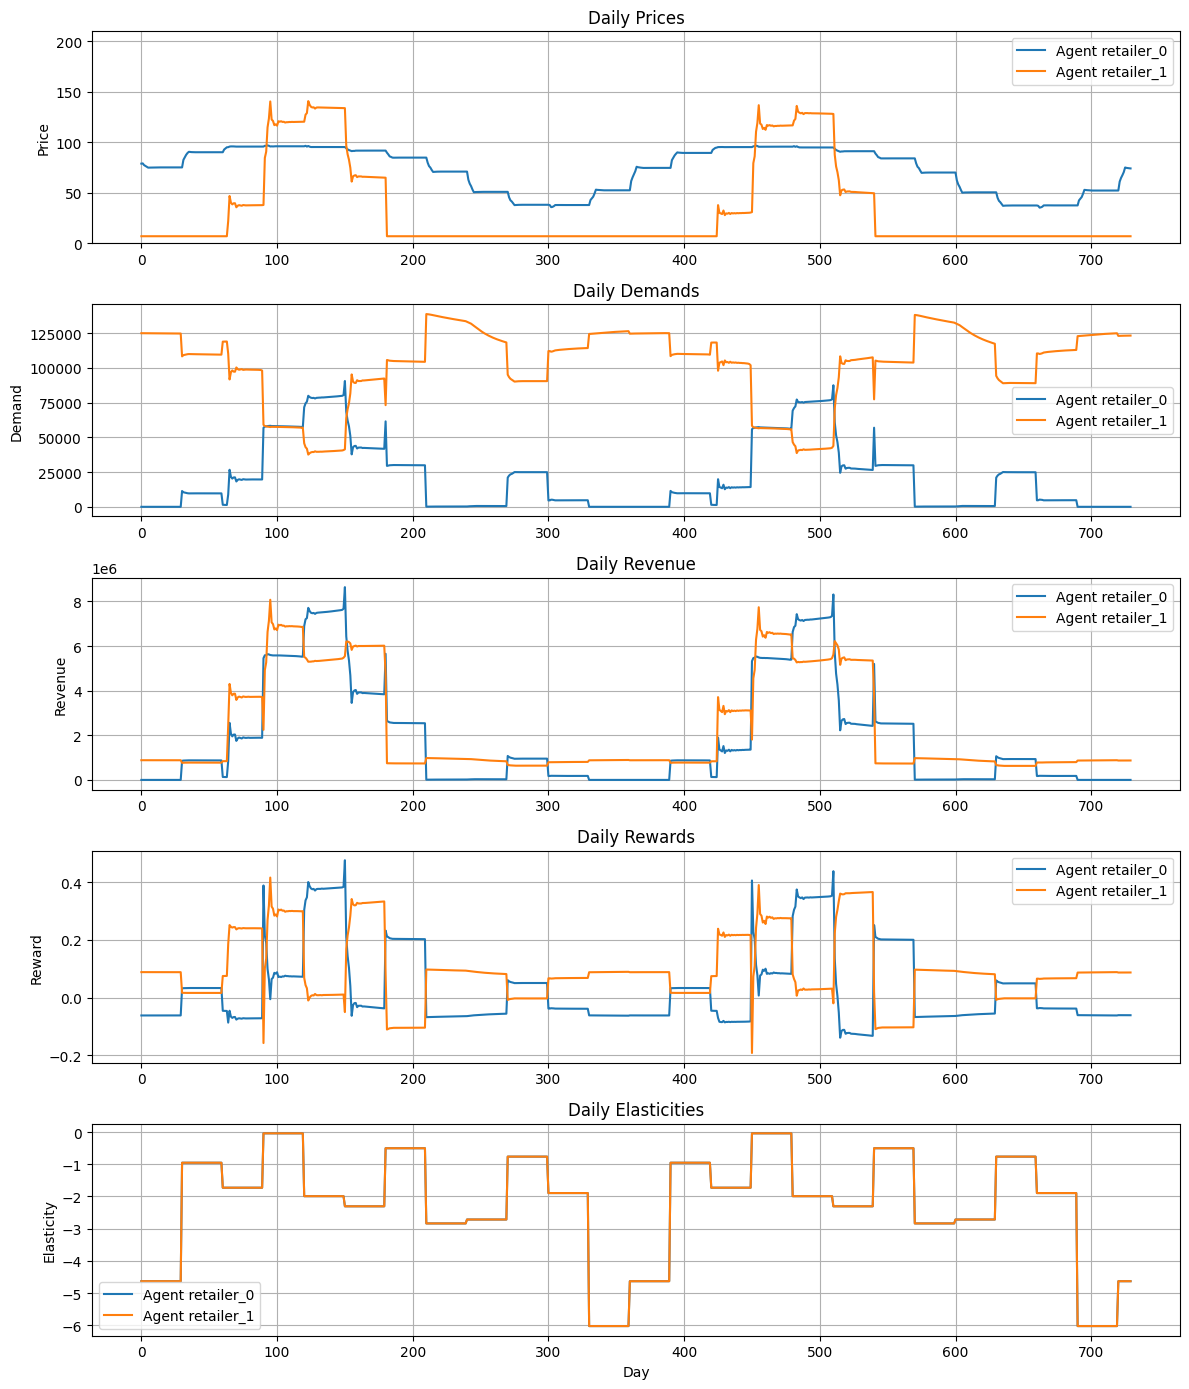

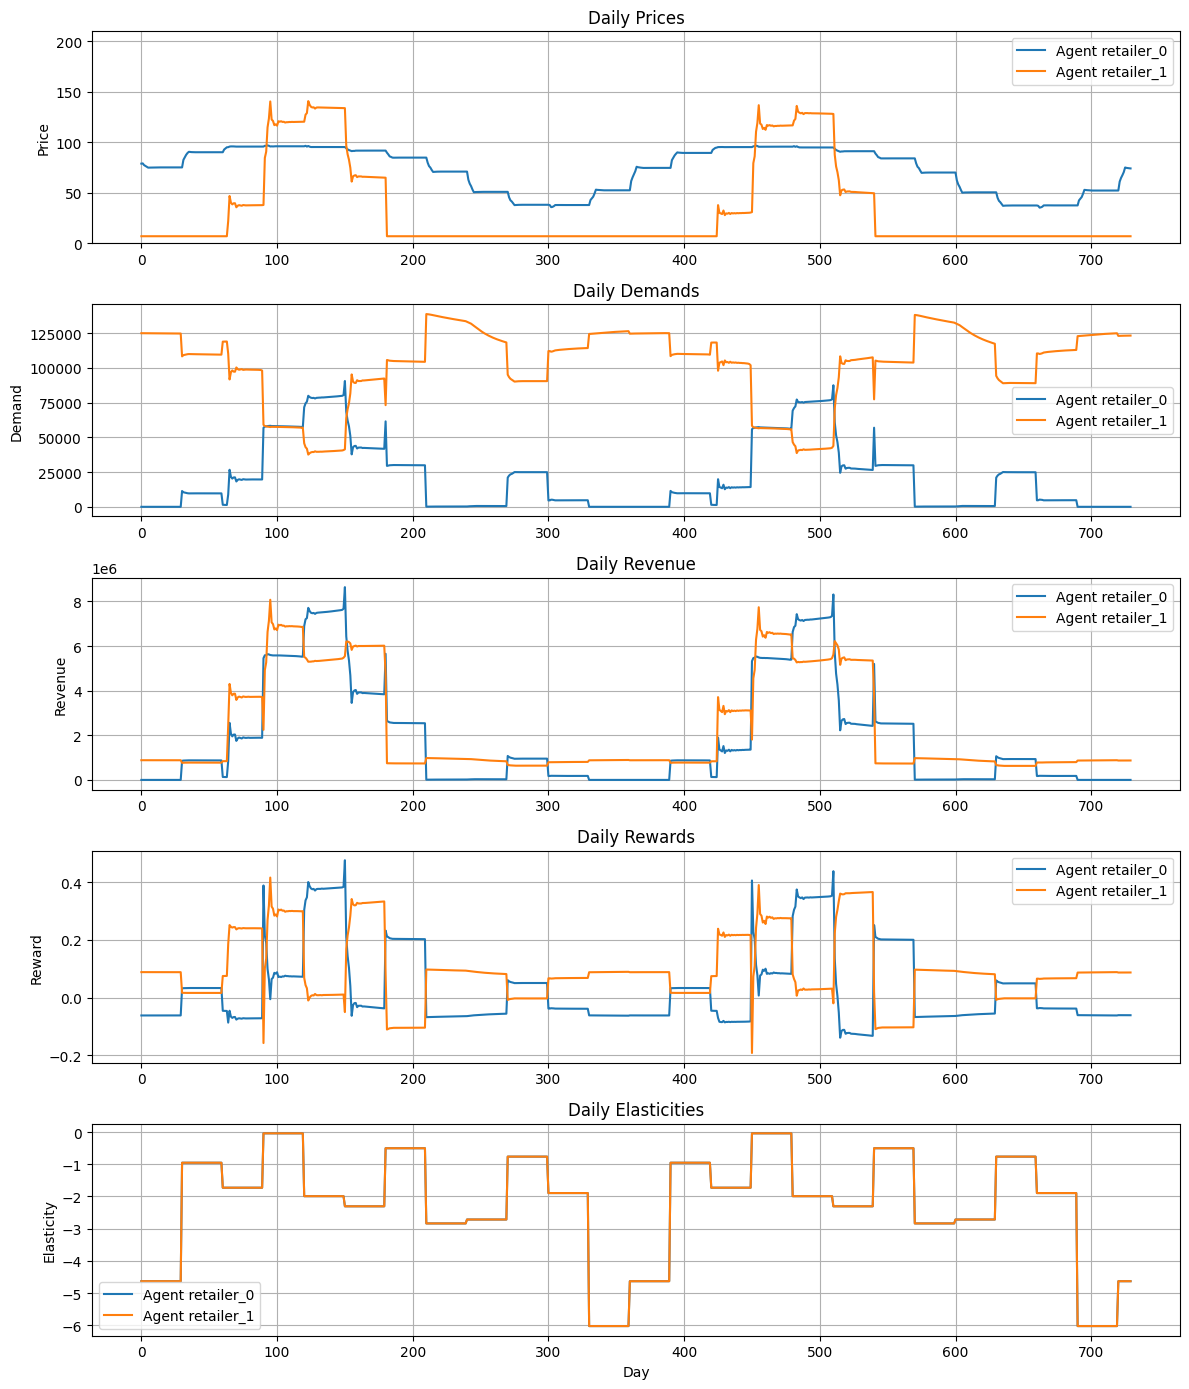

In [ ]:
import matplotlib.pyplot as plt

total_rewards, total_revenue, rewards_over_time, revenue_over_time, prices, demands, elasticities = evaluate_agents_with_metrics(env_fn, maddpg_agents, num_steps=730)
days = range(len(rewards_over_time[next(iter(rewards_over_time))]))


plt.figure(figsize=(12, 14))

# Prices
plt.subplot(5, 1, 1)
for agent_id, price_list in prices.items():
    plt.plot(days, price_list, label=f"Agent {agent_id}")
plt.title("Daily Prices")
plt.ylabel("Price")
plt.ylim(0,210)
plt.legend()
plt.grid(True)

# Demands
plt.subplot(5, 1, 2)
for agent_id, demand_list in demands.items():
    plt.plot(days, demand_list, label=f"Agent {agent_id}")
plt.title("Daily Demands")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)

# Revenue
plt.subplot(5, 1, 3)
for agent_id, revenue_list in revenue_over_time.items():
    plt.plot(days, revenue_list, label=f"Agent {agent_id}")
plt.title("Daily Revenue")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)

# Rewards
plt.subplot(5, 1, 4)
for agent_id, reward_list in rewards_over_time.items():
    plt.plot(days, reward_list, label=f"Agent {agent_id}")
plt.title("Daily Rewards")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)

# Elasticities
plt.subplot(5, 1, 5)
for agent_id, elast_list in elasticities.items():
    plt.plot(days, elast_list, label=f"Agent {agent_id}")
plt.title("Daily Elasticities")
plt.ylabel("Elasticity")
plt.xlabel("Day")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Number of time steps
num_steps = len(next(iter(rewards_over_time.values())))

# Build a dictionary for the DataFrame
data = {}
for agent_id in rewards_over_time.keys():
    data[f"{agent_id}_reward"] = rewards_over_time[agent_id]
    data[f"{agent_id}_revenue"] = revenue_over_time[agent_id]
    data[f"{agent_id}_price"] = prices[agent_id]
    data[f"{agent_id}_demand"] = demands[agent_id]
    data[f"{agent_id}_elasticity"] = elasticities[agent_id]

df_agents = pd.DataFrame(data)
df_agents['day'] = range(num_steps)
df_agents = df_agents.set_index('day')
print(df_agents.head())
df_agents.to_csv("agent_metrics_over_time.csv")


     retailer_0_reward  retailer_0_revenue  retailer_0_price  \
day                                                            
0            -0.061762          137.926040         78.972885   
1            -0.061760          136.571679         79.187126   
2            -0.061755          147.646674         77.502930   
3            -0.061750          153.591992         76.663078   
4            -0.061745          160.669073         75.715973   

     retailer_0_demand  retailer_0_elasticity  retailer_1_reward  \
day                                                                
0             1.746499              -4.629728           0.088242   
1             1.724670              -4.629728           0.088239   
2             1.905046              -4.629728           0.088233   
3             2.003468              -4.629728           0.088226   
4             2.121997              -4.629728           0.088219   

     retailer_1_revenue  retailer_1_price  retailer_1_demand  \
day       

## Compare againts baseline

In [ ]:
print(env.possible_agents)

['retailer_0', 'retailer_1']


Agent vs fixed baseline function

In [ ]:
import numpy as np
import pandas as pd

def fixed_price_policy_scaled(scaled_value=0.70):
    """Return a policy that outputs a normalized action matching a fixed scaled price."""
    norm = 2.0 * float(scaled_value) - 1.0  # map [0,1] -> [-1,1]
    norm = float(np.clip(norm, -1.0, 1.0))
    a = np.array([norm], dtype=np.float32)
    def _policy(_obs):
        return a.copy()
    return _policy

def evaluate_vs_baseline(env, maddpg_agents, baseline_scaled_price=0.70, n_steps=730):
    rl_agent_name = "retailer_1"
    baseline_policy = fixed_price_policy_scaled(baseline_scaled_price)

    results = []
    obs, _ = env.reset()

    for step in range(n_steps):
        actions = {}
        for agent in env.possible_agents:
            if agent == rl_agent_name:
                a = maddpg_agents[rl_agent_name].select_action(obs[agent], noise_scale=0.0)
                a = np.asarray(a, dtype=np.float32).reshape(-1)
                a = np.clip(a, -1.0, 1.0)
                actions[agent] = a
            else:
                actions[agent] = baseline_policy(obs[agent])  # already normalized [-1,1]

        next_obs, rewards, terminations, truncations, infos = env.step(actions)

        # log from infos (real units + elasticity from env)
        for agent in env.possible_agents:
            info = infos.get(agent, {})
            price_real  = float(info.get("price", np.nan))
            demand_real = float(info.get("demand", np.nan))
            elasticity  = info.get("elasticity", np.nan)

            a_norm = float(np.asarray(actions[agent]).reshape(-1)[0])
            a_scaled = (a_norm + 1.0) / 2.0

            results.append({
                "step": step,
                "agent": agent,
                "action_norm": a_norm,
                "price_scaled": a_scaled,
                "price": price_real,
                "demand": demand_real,
                "revenue": price_real * demand_real if np.isfinite(price_real) and np.isfinite(demand_real) else np.nan,
                "reward": float(rewards[agent]),
                "elasticity": float(elasticity) if elasticity is not None else np.nan,
            })

        obs = next_obs
        if all(terminations.values()) or all(truncations.values()):
            break

    return pd.DataFrame(results)


In [ ]:
env2 = env_fn()
maddpg_agents_dict = {"retailer_1": maddpg_agents[1]}
df_vs_baseline = evaluate_vs_baseline(
    env2,
    maddpg_agents=maddpg_agents_dict,
    baseline_scaled_price=0.70
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vs_baseline_results(df):
    agents = df["agent"].unique()
    fig, axes = plt.subplots(5, 1, figsize=(12, 14), sharex=True)

    # --- Price ---
    for agent in agents:
        agent_df = df[df["agent"] == agent]
        prices = [a[0] if isinstance(a, (list, np.ndarray)) else a for a in agent_df["price"]]
        axes[0].plot(agent_df["step"], prices, label=agent)
    axes[0].set_ylabel("Price")
    axes[0].legend()
    axes[0].set_ylim(0, 210)
    axes[0].grid(True)

    # --- Demand ---
    for agent in agents:
        agent_df = df[df["agent"] == agent]
        demands = [d[0] if isinstance(d, (list, np.ndarray)) else d for d in agent_df["demand"]]
        axes[1].plot(agent_df["step"], demands, label=agent)
    axes[1].set_ylabel("Demand")
    axes[1].grid(True)

    # --- Revenue ---
    for agent in agents:
        agent_df = df[df["agent"] == agent]
        axes[2].plot(agent_df["step"], agent_df["revenue"], label=agent)
    axes[2].set_ylabel("Revenue")
    axes[2].grid(True)

    # --- Reward ---
    for agent in agents:
        agent_df = df[df["agent"] == agent]
        axes[3].plot(agent_df["step"], agent_df["reward"], label=agent)
    axes[3].set_ylabel("Reward")
    axes[3].grid(True)

    # --- Elasticity ---
    for agent in agents:
        agent_df = df[df["agent"] == agent]
        axes[4].plot(agent_df["step"], agent_df["elasticity"], label=agent)
    axes[4].set_ylabel("Elasticity")
    axes[4].set_xlabel("Time Step")
    axes[4].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
print("price data_min_, data_max_:", scaler_price.data_min_, scaler_price.data_max_)

price data_min_, data_max_: [6.8691344] [199.18433]


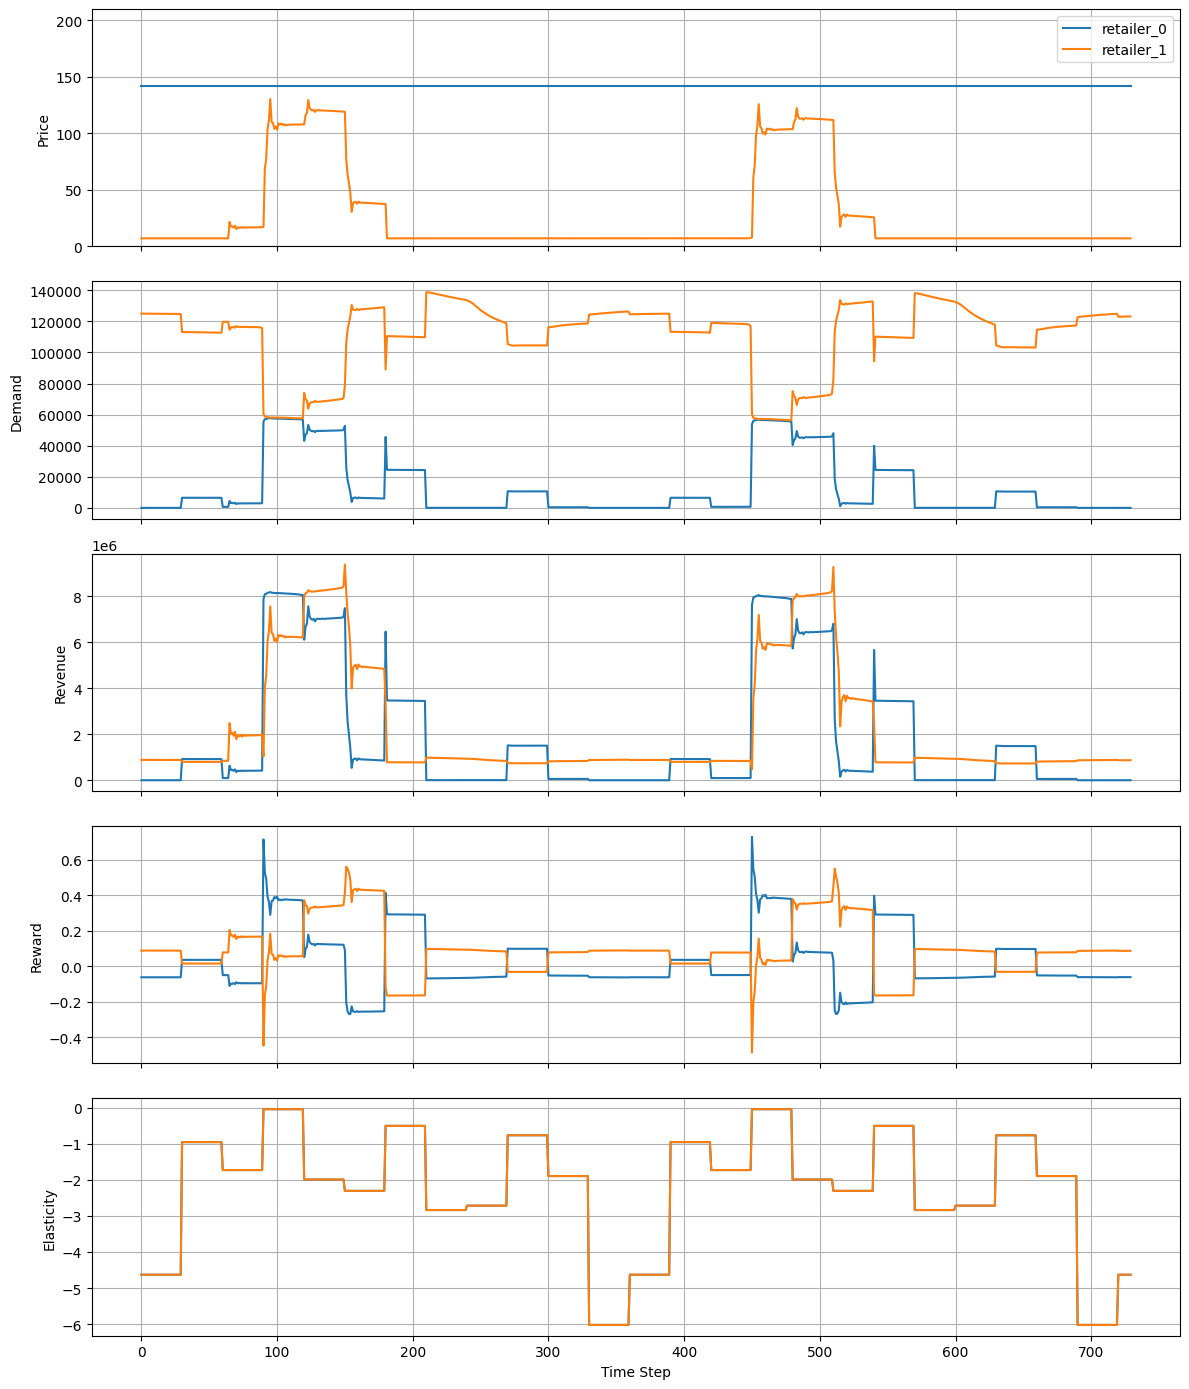

In [ ]:
plot_vs_baseline_results(df_vs_baseline)


In [ ]:
revenue_per_agent = df_vs_baseline.groupby("agent")["revenue"].sum()
print("Total revenue per agent:")
print(revenue_per_agent)

Total revenue per agent:
agent
retailer_0    1.320322e+09
retailer_1    1.610505e+09
Name: revenue, dtype: float64


In [ ]:
reward_per_agent = df_vs_baseline.groupby("agent")["reward"].sum()
print("Total reward per agent:")
print(reward_per_agent)

Total reward per agent:
agent
retailer_0    19.296861
retailer_1    68.627960
Name: reward, dtype: float64


In [ ]:
df_vs_baseline.to_csv("vs_baseline_results2.csv", index=False)

## Market share showcase

In [ ]:
import numpy as np
import pandas as pd

epsilon = -0.05
D_max = 100.0
prices = np.arange(0.1, 1.01, 0.1)

# Compute revenue for agent 0
revenue0_grid = np.zeros((len(prices), len(prices)))
revenue1_grid = np.zeros((len(prices), len(prices)))

for i, p0 in enumerate(prices):
    for j, p1 in enumerate(prices):
        s0 = p0**epsilon / (p0**epsilon + p1**epsilon)
        D0 = s0 * D_max
        revenue0_grid[i, j] = np.round(D0 * p0,2)  # revenue = price * demand

for i, p0 in enumerate(prices):
    for j, p1 in enumerate(prices):
        s1 = p1**epsilon / (p0**epsilon + p1**epsilon)
        D1 = s1 * D_max
        revenue1_grid[i, j] = np.round(D1 * p1,2)  # revenue = price * demand

# Convert to DataFrame
df_revenue0 = pd.DataFrame(revenue0_grid, index=[f"{p0:.2f}" for p0 in prices],
                          columns=[f"{p1:.2f}" for p1 in prices])
df_revenue0.to_csv("revenue_grid p0.csv")

df_revenue1 = pd.DataFrame(revenue1_grid, index=[f"{p0:.2f}" for p0 in prices],
                          columns=[f"{p1:.2f}" for p1 in prices])
df_revenue1.to_csv("revenue_grid p1.csv")




In [ ]:
print(df_revenue0)

       0.10   0.20   0.30   0.40   0.50   0.60   0.70   0.80   0.90   1.00
0.10   5.00   5.09   5.14   5.17   5.20   5.22   5.24   5.26   5.27   5.29
0.20   9.83  10.00  10.10  10.17  10.23  10.27  10.31  10.35  10.38  10.40
0.30  14.59  14.85  15.00  15.11  15.19  15.26  15.32  15.37  15.41  15.45
0.40  19.31  19.65  19.86  20.00  20.11  20.20  20.28  20.35  20.41  20.46
0.50  23.99  24.43  24.68  24.86  25.00  25.11  25.21  25.29  25.37  25.43
0.60  28.66  29.18  29.48  29.70  29.86  30.00  30.12  30.22  30.30  30.38
0.70  33.30  33.90  34.26  34.51  34.71  34.87  35.00  35.12  35.22  35.31
0.80  37.92  38.61  39.02  39.31  39.53  39.71  39.87  40.00  40.12  40.22
0.90  42.53  43.31  43.76  44.09  44.34  44.54  44.72  44.87  45.00  45.12
1.00  47.12  47.99  48.50  48.85  49.13  49.36  49.55  49.72  49.87  50.00


In [ ]:
print(df_revenue1)

      0.10   0.20   0.30   0.40   0.50   0.60   0.70   0.80   0.90   1.00
0.10  5.00   9.83  14.59  19.31  23.99  28.66  33.30  37.92  42.53  47.12
0.20  5.09  10.00  14.85  19.65  24.43  29.18  33.90  38.61  43.31  47.99
0.30  5.14  10.10  15.00  19.86  24.68  29.48  34.26  39.02  43.76  48.50
0.40  5.17  10.17  15.11  20.00  24.86  29.70  34.51  39.31  44.09  48.85
0.50  5.20  10.23  15.19  20.11  25.00  29.86  34.71  39.53  44.34  49.13
0.60  5.22  10.27  15.26  20.20  25.11  30.00  34.87  39.71  44.54  49.36
0.70  5.24  10.31  15.32  20.28  25.21  30.12  35.00  39.87  44.72  49.55
0.80  5.26  10.35  15.37  20.35  25.29  30.22  35.12  40.00  44.87  49.72
0.90  5.27  10.38  15.41  20.41  25.37  30.30  35.22  40.12  45.00  49.87
1.00  5.29  10.40  15.45  20.46  25.43  30.38  35.31  40.22  45.12  50.00
